# All needed imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
sess = tf.Session()
K.set_session(sess)

# Load mnist dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

## Create VAE submodels 

In [4]:
batch_size = 500
latent_dim = 49
dropout_rate = 0.3

### Encoder

In [5]:
input_ae_encoder = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=(5, 5))(input_ae_encoder)
x = LeakyReLU()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=(5, 5))(x)
x = LeakyReLU()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

begin_of_dense = Flatten()(x)
x = LeakyReLU()(begin_of_dense)
x = Dense(latent_dim * 4)(x)
x = LeakyReLU()(x)
encoded = Dense(latent_dim, activation='relu')(x)
ae_encoder = Model(input_ae_encoder, encoded, name='Encoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Decoder

In [6]:
input_ae_decoder = Input(shape=(latent_dim,))

x = Dense(latent_dim)(input_ae_decoder)
x = Reshape(target_shape=(7, 7, 1))(x)
x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)
ae_decoder = Model(input_ae_decoder, decoded, name='Decoder')

### VAE Model

In [7]:
ae_model = Model(input_ae_encoder, ae_decoder(ae_encoder(input_ae_encoder)), name='ConvAE')
ae_model.compile(loss='binary_crossentropy', optimizer='adam')
ae_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
EncoderAE (Model)            (None, 49)                73673     
_________________________________________________________________
DecoderAE (Model)            (None, 28, 28, 1)         17651     
Total params: 91,324
Trainable params: 91,324
Non-trainable params: 0
_________________________________________________________________


### VAE Model Training

In [11]:
import time

from keras.callbacks import LambdaCallback


imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

epochs_to_check = np.linspace(0, 100, num=10).astype('int')


digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        decoded_imgs = ae_model.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded_imgs[:n_compare])


plt_fig = LambdaCallback(on_epoch_end=on_epoch_end)

start_time = time.time()
ae_model.fit(x_train, x_train,
              batch_size=batch_size,
              epochs=100,
              shuffle=True,
              validation_data=(x_test, x_test),
              callbacks=[plt_fig],
              verbose=1)
print("ALL VAE TRAINING ELAPSED TIME: %s" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
Traceback (most recent call last):
  File "d:\diploma\vae\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f16a00d00454>", line 48, in <module>
    verbose=1)
  File "d:\diploma\vae\venv\lib\site-packages\keras\engine\training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "d:\diploma\vae\venv\lib\site-packages\keras\engine\training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "d:\diploma\vae\venv\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3476, in __call__
    run_metadata=self.run_metadata)
  File "d:\diploma\vae\venv\lib\site-packages\tensorflow_core\python\client\session.py", line 1472, in __call__
    run_metadata_ptr)
tensorflow.python.framework.errors_impl.UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution alg

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node EncoderAE/conv2d_1/convolution}}]]
	 [[Mean/_163]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node EncoderAE/conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

### Try to decode random codes

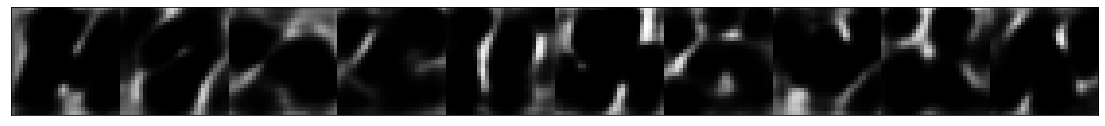

In [15]:
codes = np.random.randn(n_compare, latent_dim)
decoded_from_codes = ae_decoder.predict(codes, batch_size=n_compare)
plot_digits(decoded_from_codes)


# SAVE MODELS

In [16]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_ae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "ae.json"), "w") as f:
    json.dump(ae_model.to_json(), f, indent=4)
ae_model.save_weights(os.path.join(save_path, "ae.h5"))

with open(os.path.join(save_path, "ae_encoder.json"), "w") as f:
    json.dump(ae_encoder.to_json(), f, indent=4)
ae_encoder.save_weights(os.path.join(save_path, "ae_encoder.h5"))

with open(os.path.join(save_path, "ae_decoder.json"), "w") as f:
    json.dump(ae_decoder.to_json(), f, indent=4)
ae_decoder.save_weights(os.path.join(save_path, "ae_decoder.h5"))